In [297]:
import getpass
import os
from typing import Annotated, Sequence, TypedDict
from langchain_core.messages import BaseMessage, ToolMessage, SystemMessage
from langchain_core.runnables import RunnableConfig
from langgraph.graph import StateGraph, START, END, MessagesState
from langchain_openai import ChatOpenAI
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_community.tools import DuckDuckGoSearchRun
from langchain_core.messages import AIMessage, HumanMessage, ToolMessage
from dotenv import load_dotenv
from typing import List, Union
import logging
from IPython.display import display, HTML, Image

In [285]:
load_dotenv()
logger = logging.getLogger(__name__)
logging.basicConfig(level=logging.INFO)

In [286]:
class AgentState(TypedDict):
    messages: Annotated[List[Union[HumanMessage, AIMessage, ToolMessage]], add_messages]

In [287]:
model = ChatOpenAI(model="gpt-4o-mini", temperature=0)
search = DuckDuckGoSearchRun()
logger.info(f"description = {search.description}")
tools = [search]
llm_with_tools = model.bind_tools(tools)

INFO:__main__:description = A wrapper around DuckDuckGo Search. Useful for when you need to answer questions about current events. Input should be a search query.


In [288]:
tool_by_name = {tool.name: tool for tool in tools}
tool_by_name

{'duckduckgo_search': DuckDuckGoSearchRun(api_wrapper=DuckDuckGoSearchAPIWrapper(region='wt-wt', safesearch='moderate', time='y', max_results=5, backend='auto', source='text'))}

In [289]:
result = search.invoke("top 10 horror movies to watch?")
print(result)

/opt/miniconda3/envs/berkeley_ai/lib/python3.12/site-packages/langchain_community/utilities/duckduckgo_search.py:63: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  with DDGS() as ddgs:
INFO:primp:response: https://www.bing.com/search?q=top+10+horror+movies+to+watch%3F&filters=ex1%3A%22ez5_19972_20337%22 200
DEBUG:duckduckgo_search.DDGS:_get_url() https://www.bing.com/search?q=top+10+horror+movies+to+watch%3F&filters=ex1%3A%22ez5_19972_20337%22 200


No good DuckDuckGo Search Result was found


In [290]:
def call_model(state: AgentState, config: RunnableConfig):
    system_prompt = SystemMessage("You are a helpful AI assistant that searches the web."
        "Use the search tool duckduckgo_search to query the web for relevant information."
    )
    # system_prompt = SystemMessage("")
    response = llm_with_tools.invoke([system_prompt] + list(state["messages"]), config=config)
    logger.debug(f"Model response: {response}")
    return {"messages": [response]}


In [291]:
def tool_node(state: AgentState, config: RunnableConfig):
   logger.info(f"Invoking tools for {state['messages'][-1].tool_calls}")
   outputs = []
   for tool_call in state["messages"][-1].tool_calls:
      logger.info(f"tool call: {tool_call}")
      tool_result = tool_by_name[tool_call["name"]].invoke(tool_call["args"], config=config)
      logger.info(f"Tool {tool_call["name"]} returned {tool_result}")
      outputs.append(ToolMessage(
         content=str(tool_result),
         name=tool_call["name"],
         tool_call_id=tool_call["id"]
      ))

   return {"messages": outputs}

In [292]:
def should_continue(state: AgentState) -> bool:
    messages = state["messages"]
    last_message = messages[-1]
    if not last_message.tool_calls:
        logger.info("No tool calls, ending")
        return "end"
    else:
        return "continue"

In [293]:
workflow = StateGraph(AgentState)
workflow.add_node("agent", call_model)
workflow.add_node("tools", tool_node)
workflow.add_edge(START, "agent")
workflow.add_conditional_edges("agent", should_continue, {"continue": "tools", "end": END})
workflow.add_edge("tools", "agent")

In [294]:
memory = MemorySaver()
graph = workflow.compile(checkpointer=memory)
config = {"configurable": {"thread_id": "thread_1"}}

DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): mermaid.ink:443
DEBUG:urllib3.connectionpool:https://mermaid.ink:443 "GET /img/LS0tCmNvbmZpZzoKICBmbG93Y2hhcnQ6CiAgICBjdXJ2ZTogbGluZWFyCi0tLQpncmFwaCBURDsKCV9fc3RhcnRfXyhbPHA+X19zdGFydF9fPC9wPl0pOjo6Zmlyc3QKCWFnZW50KGFnZW50KQoJdG9vbHModG9vbHMpCglfX2VuZF9fKFs8cD5fX2VuZF9fPC9wPl0pOjo6bGFzdAoJX19zdGFydF9fIC0tPiBhZ2VudDsKCWFnZW50IC0uICZuYnNwO2VuZCZuYnNwOyAuLT4gX19lbmRfXzsKCWFnZW50IC0uICZuYnNwO2NvbnRpbnVlJm5ic3A7IC4tPiB0b29sczsKCXRvb2xzIC0tPiBhZ2VudDsKCWNsYXNzRGVmIGRlZmF1bHQgZmlsbDojZjJmMGZmLGxpbmUtaGVpZ2h0OjEuMgoJY2xhc3NEZWYgZmlyc3QgZmlsbC1vcGFjaXR5OjAKCWNsYXNzRGVmIGxhc3QgZmlsbDojYmZiNmZjCg==?type=png&bgColor=!white HTTP/1.1" 200 10528


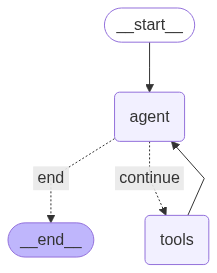

In [298]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [280]:
response = graph.invoke({
    "messages": [HumanMessage(content="search top 10 horror movies to watch?")]
}, config=config)

DEBUG:openai._base_client:Request options: {'method': 'post', 'url': '/chat/completions', 'files': None, 'idempotency_key': 'stainless-python-retry-f02ff509-6779-456a-a4ca-fd9fe856c1b8', 'json_data': {'messages': [{'content': 'You are a helpful AI assistant that searches the web.Use the search tool duckduckgo_search to query the web for relevant information.', 'role': 'system'}, {'content': 'search top 10 horror movies to watch?', 'role': 'user'}], 'model': 'gpt-4o-mini', 'stream': False, 'temperature': 0.0, 'tools': [{'type': 'function', 'function': {'name': 'duckduckgo_search', 'description': 'A wrapper around DuckDuckGo Search. Useful for when you need to answer questions about current events. Input should be a search query.', 'parameters': {'properties': {'query': {'description': 'search query to look up', 'type': 'string'}}, 'required': ['query'], 'type': 'object'}}}]}}
DEBUG:openai._base_client:Sending HTTP Request: POST https://api.openai.com/v1/chat/completions
DEBUG:httpcore.c

In [281]:
print(response["messages"][-1].content)

It seems that I am unable to find specific lists of top horror movies for 2023. However, I can suggest some popular horror movies that have been well-received in recent years. Here are some notable titles you might consider watching:

1. **Hereditary (2018)** - A psychological horror film that explores family trauma and grief.
2. **Get Out (2017)** - A social thriller that combines horror with sharp commentary on race relations.
3. **A Quiet Place (2018)** - A suspenseful film about a family living in silence to avoid blind monsters that hunt by sound.
4. **The Invisible Man (2020)** - A modern adaptation of the classic story that focuses on themes of abuse and control.
5. **Midsommar (2019)** - A folk horror film that takes place during a summer festival in Sweden, exploring themes of grief and relationships.
6. **The Conjuring series** - A franchise based on real-life paranormal investigators Ed and Lorraine Warren.
7. **It Follows (2014)** - A unique horror film about a supernatural